<img src="PEST++V3_cover.jpeg" style="float: left">

<img src="flopylogo.png" style="float: right">

<img src="AW&H2015.png" style="float: center">

# Looking at Global Sensitivity Analyses (GSA)

Sensitivity methods we've looked at so far only evaluate the "local" sensitivity at a single set of parameter values.  For example, the Jacobian matrix represents perturbations to a single set of parameter values.  This local view can be a problem in cases when our inverse problem is nonlinear, which means the parameter sensitivities can change depending on what the parameter value is. In contrast, Global Sensitivity Analyses are statistical approaches that try to characterize how model parameters affect model outputs over a __wide range__ of acceptable parameter values. Because we often are interested in a number of parameter sets GSA methods provide a more representative view of parameter estimation compared to traditional, derivative-based local sensitivity analysis. Some GSA methods provide general information about the variability of the sensitivities and have relatively low computational requirements, whereas others provide detailed information on nonlinear behavior and interactions between parameters at the expense of larger computational requirements. For a complete introduction to GSA theory and methods, see Saltelli and others (2004, 2008).

### Local Sensitivity Equation
Recall the local sensitivity equation (eq. 9.7 Anderson et al. 2015):

<img src="Sensitivity_eq.png" style="float: center">

In GSA the change in parameter is not just small perturbations (usually 1%) around the parameter value but rather spans the reasonable parameter range.  What is a reasonable range?  For convenience GSA++ uses the parameter bounds that you specify in your PEST Control File.

### Lots of parameters evaluated = lots of computer time.  Using the PEST++ engine to run GSA in parallel

GSA++ is a stand-alone program distributed with the PEST++ Version 3 suite of tools that perform GSA. It leverages the PEST++ parallel run manger YAMR, and is fully compatible with PEST/PEST++ file formats, including template and instruction files. For us this means we can access the insight of GSA using parallel computing without changing our files. More GSA++ running details are provided in appendix 6 of the PEST++ V3 Techniques and Methods Report. Appendixes 7 and 8 demonstrate the use of GSA++ for a Method of Morris and Sobol example problem.  In this notebook we'll run GSA on the Freyburg model.

### Last bit of GSA Method of Morris Theory from PEST++ T&M Report (Welter et al. 2015 pages 5-7):

The program GSA++ currently supports two GSA methods: (1) the __Method of Morris__ (Morris, 1991), and (2) the __Method of Sobol__ (Sobol, 2001). In the class we'll focus on the Method of Morris because it is computationally more efficient. But this efficiency comes with a tradeoff: the Method of Morris only provides estimates of the mean and variance of the sensitivity distribution for each parameter. Because of the lack of complete description of the parameter nonlinearity and interactions between parameters, the Method of Morris can be used as a screening-level tool to identify the most important parameters for the observations tested. This screening can be followed by application of a more comprehensive tool, such as the Method of Sobol, which further characterizes the effects of parameter nonlinearity and inter-parameter interactions. 

The Method of Morris is referred to as a “one-at-a-time” method because each parameter is perturbed sequentially to compute sensitivities, which is ideally suited for parallel computing. The method samples the sensitivity of a given parameter at several locations over the range of reasonable parameter space (__defined by the parameter bounds in the PEST Control file__) and then provides two measures of parameter sensitivity: the mean (__μ__) and the standard deviation (__σ__) of the resulting sensitivity distribution. The mean, __μ__, captures the overall effect of a parameter on the model output of interest; the standard deviation, __σ__, measures a parameter’s sensitivity across the range of acceptable parameter values, this being an indicator of how nonlinear a given parameter is and (or) how the parameter interacts with other parameters. It is important to note that the Method of Morris __cannot distinguish__ between parameter nonlinearity and parameter interactions because only the standard deviation of parameter sensitivity is available. 

#### For the class we'll focus on the easiest way to get in the GSA game using pyemu, but this is also likely what you would start with in 95% of the models you evaluate.  For convenience, widely applicable default values are supplied for you by pyemu but can easily be changed by editing the *.gsa* file pyemu creates  (see Appendix 6 in the PEST++ V3 report for descriptions of the *.gsa* variables). 


In [1]:
%matplotlib inline
import os
import shutil
import sys
sys.path.append("..")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyemu

#from matplotlib.backends.backend_pdf import PdfPages

In [2]:
import freyberg_setup as fs
pst_name = fs.PST_NAME_ZN
working_dir = fs.WORKING_DIR_ZN
fs.setup_pest_zn()

['botm.ref', 'extract_zone_array.py', 'forecasts_true.csv', 'freyberg.bas', 'freyberg.dbf', 'freyberg.dis', 'freyberg.hds', 'freyberg.heads', 'freyberg.heads_potobs.ins', 'freyberg.hyd', 'freyberg.list', 'freyberg.locations', 'freyberg.mpbas', 'freyberg.mpenpt', 'freyberg.mplist', 'freyberg.mpnam', 'freyberg.mppthln', 'freyberg.mpsim', 'freyberg.oc', 'freyberg.pcg', 'freyberg.rivflux', 'freyberg.shp', 'freyberg.shx', 'freyberg.travel', 'freyberg.truth.lpf', 'freyberg.truth.nam', 'freyberg.truth.rch', 'freyberg.truth.riv', 'freyberg.truth.wel', 'hk.truth.ref', 'hk.zones', 'ibound.ref', 'kzone.ref', 'mpath.in', 'obs_loc.csv', 'potobs_group.csv', 'Process_output.py', 'run_true_model.py', 'strt.ref', 'Weights_and_best_PHI.xlsx']

changing model workspace...
   freyberg_zn
FloPy is using the following executable to run the model: E:\git\GW1876\activities\freyberg_global_sensitivity\freyberg_zn\mfnwt.exe

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR 

### First let's calculate a single Jacobian - it represents local-scale sensitivity information

In [3]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
pst.control_data.noptmax = -1
pst.write(os.path.join(working_dir,pst_name))
pyemu.helpers.run("pestpp {0}".format(pst_name),cwd=working_dir)

run():pestpp.exe freyberg_zn.pst


### Now, let's run GSA, a global sensitivity analysis tool.  By default (no extra settings), GSA will run the Method of Morris with 4 discretization points for each parameter...

In [4]:
os.chdir(working_dir)
pyemu.helpers.start_slaves('.',"gsa",pst_name,num_slaves=15,master_dir=".")
os.chdir("..")

master:gsa freyberg_zn.pst /h :4004 in .
slave:gsa freyberg_zn.pst /h localhost:4004 in ..\slave_0
slave:gsa freyberg_zn.pst /h localhost:4004 in ..\slave_1
slave:gsa freyberg_zn.pst /h localhost:4004 in ..\slave_2
slave:gsa freyberg_zn.pst /h localhost:4004 in ..\slave_3
slave:gsa freyberg_zn.pst /h localhost:4004 in ..\slave_4
slave:gsa freyberg_zn.pst /h localhost:4004 in ..\slave_5
slave:gsa freyberg_zn.pst /h localhost:4004 in ..\slave_6
slave:gsa freyberg_zn.pst /h localhost:4004 in ..\slave_7
slave:gsa freyberg_zn.pst /h localhost:4004 in ..\slave_8
slave:gsa freyberg_zn.pst /h localhost:4004 in ..\slave_9
slave:gsa freyberg_zn.pst /h localhost:4004 in ..\slave_10
slave:gsa freyberg_zn.pst /h localhost:4004 in ..\slave_11
slave:gsa freyberg_zn.pst /h localhost:4004 in ..\slave_12
slave:gsa freyberg_zn.pst /h localhost:4004 in ..\slave_13
slave:gsa freyberg_zn.pst /h localhost:4004 in ..\slave_14


In [5]:
os.getcwd()

'E:\\git\\GW1876\\activities\\freyberg_global_sensitivity'

### Look at the Jacobian matrix---gradients of parameters wrt. observations

For each parameter-observation combination, we can see how much the observation value changes due to a small change in the parameter. If $y$ are the observations and $x$ are the parameters, the equation for the $i^th$ observation with respect to the $j^th$ parameter is:  
## $\frac{\partial y_i}{\partial x_j}$
This can be approximated by finite differences as :  
## $\frac{\partial y_i}{\partial x_j}~\frac{y\left(x+\Delta x \right)-y\left(x\right)}{\Delta x}$

### First we can read in a couple Jacobian matrices -- one from our simple model, and one from a more complex one

In [6]:
jco = pyemu.Jco.from_binary(os.path.join(working_dir,pst_name.replace(".pst",".jcb")))
jco_df = jco.to_dataframe()

In [7]:
jco_df = jco_df.loc[pst.nnz_obs_names,:]
jco_df

,rch_0,rch_1,hk_z01,hk_z02,hk_z03,hk_z04,hk_z05,hk_z06
flx_river_l_19700102,-12744.213423,0.0,-0.338976,-9.265355,5.367126,72.427959,-169.714187,-153.612808
cr03c10_19700102,12.077359,0.0,0.020303,-1.610138,-8.570630,-0.892903,-0.226867,-0.135944
cr03c16_19700102,1.401809,0.0,0.000000,-0.573347,-0.485072,-0.030014,-0.001766,-0.000883
cr04c09_19700102,13.683965,0.0,0.017655,-2.276615,-9.204445,-1.045177,-0.271005,-0.164192
cr10c02_19700102,22.782922,0.0,-0.076799,-7.769092,-11.248897,-1.353257,-0.831551,-0.602036
cr14c11_19700102,6.176168,0.0,-0.001324,-0.084303,-0.839496,-2.429772,-0.927771,-0.127116
cr16c17_19700102,2.380780,0.0,0.000000,-0.036193,-0.167723,-1.738578,-0.062234,-0.015890
cr22c11_19700102,8.029945,0.0,-0.003090,0.129764,0.132854,-1.888646,-3.801567,-0.814338
cr23c16_19700102,1.430939,0.0,0.000000,0.036634,0.070179,-0.905261,-0.457044,-0.071724
cr25c05_19700102,18.254409,0.0,-0.015007,-1.257038,-6.013300,-3.302813,-3.210124,-2.276174


# How about Composite Scaled Sensitivities
In the traditional, overdetermined regression world, CSS was a popular metric. CSS is Composite Scaled Sensitivitity.

In Hill and Tiedeman (2007) this is calculated as: 
## ${css_{j}=\sqrt{\left(\sum_{i-1}^{ND}\left(\frac{\partial y'_{i}}{\partial b_{j}}\right)\left|b_{j}\right|\sqrt{w_{ii}}\right)/ND}}$

In PEST, Doherty calculates it slightly differently in that scaling by the parameter values happens automatically when the parameter is subjected to a log-transform. This is due to a correction that must be made in calculating the Jacobian matrix and follows from the chain rule of derivatives.


In [8]:
sc = pyemu.Schur(jco=os.path.join(working_dir,pst_name.replace(".pst",".jcb")))
css_df = sc.get_par_css_dataframe()
css_df

,pest_css,hill_css
rch_0,92.229968,0.000000
rch_1,0.000000,0.000000
hk_z01,0.029912,0.001493
hk_z02,2.996076,0.149583
hk_z03,6.428243,0.320939
hk_z04,2.394663,0.119557
hk_z05,3.008999,0.150229
hk_z06,2.368670,0.118259


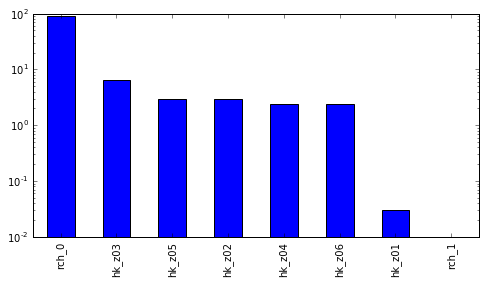

In [9]:
plt.figure(figsize=(8,4))
ax = css_df['pest_css'].sort_values(ascending=False).plot(kind='bar')
ax.set_yscale('log')

In [10]:
jco_fore_df = sc.forecasts.to_dataframe()
jco_fore_df

,fr03c10_19750102,fr03c16_19750102,fr04c09_19750102,fr10c02_19750102,fr14c11_19750102,fr16c17_19750102,fr22c11_19750102,fr23c16_19750102,fr25c05_19750102,fr27c07_19750102,fr30c16_19750102,fr34c08_19750102,fr35c11_19750102,flx_river_l_19750102,travel_time
rch_0,0.000000,0.000000,0.000000,-0.000441,0.000000,0.000000,0.000000,0.000000,-0.000441,0.000000,0.000000,0.000000,0.000000,0.056496,0.000000
rch_1,-0.001766,-0.000441,-0.002207,-0.007503,-0.001766,-0.000883,-0.001324,-0.000441,-0.004414,-0.002648,-0.000441,-0.000883,-0.000441,2.033858,4.628158
hk_z01,0.014565,0.000000,0.012800,-0.059144,-0.000883,0.000000,-0.002207,0.000000,-0.011476,-0.007062,0.000000,-0.003090,-0.001545,-0.225984,37.025263
hk_z02,-1.077398,-0.222895,-1.592042,-6.030514,-0.020303,-0.018979,0.112109,0.035972,-0.854062,-0.309846,0.010814,-0.059144,-0.035751,-3.728740,3232.768259
hk_z03,-6.083920,-0.346038,-6.636964,-8.727760,0.064441,-0.004414,0.192440,0.072165,-4.655629,-0.888930,0.035972,-0.013683,-0.018317,4.632678,-4880.392454
hk_z04,-0.640877,-0.014124,-0.751221,-0.951606,-1.396954,-1.099908,-0.719442,-0.564519,-2.281470,-2.502599,-0.051862,-0.363252,-0.077461,20.282088,305.458418
hk_z05,-0.144771,-0.001324,-0.175226,-0.550837,-0.737539,-0.046344,-2.561302,-0.357293,-2.160533,-2.890568,-0.496547,-1.779185,-0.916296,-121.551289,-36083.432687
hk_z06,-0.091365,-0.000441,-0.112551,-0.450203,-0.086951,-0.011917,-0.586588,-0.052965,-1.746964,-2.296477,-0.411583,-3.118318,0.041489,-206.097654,-15865.325114


### Now let's consider correlation and posterior covariance

In [11]:
covar = pyemu.Cov(sc.xtqx.x, names=sc.xtqx.row_names)
covar.df().head()

,rch_0,rch_1,hk_z01,hk_z02,hk_z03,hk_z04,hk_z05,hk_z06
rch_0,1.667248e+06,1.502401e-47,-1.306409e+00,-5.333607e+03,-1.632465e+04,-1.484149e+04,1.565111e+04,1.533650e+04
rch_1,1.502401e-47,9.799090e-46,5.651185e-51,-8.180376e-49,-2.209736e-48,-2.063265e-48,5.074956e-48,9.428208e-48
hk_z01,-1.306409e+00,5.651185e-51,1.753697e-01,1.372384e+01,1.579669e+01,3.897928e+00,4.912664e+00,3.674541e+00
hk_z02,-5.333607e+03,-8.180376e-49,1.372384e+01,1.759389e+03,3.270214e+03,5.056838e+02,3.585627e+02,2.673075e+02
hk_z03,-1.632465e+04,-2.209736e-48,1.579669e+01,3.270214e+03,8.099173e+03,1.501126e+03,9.959826e+02,6.975312e+02


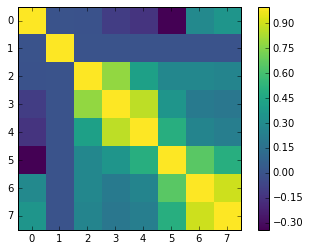

In [12]:
R = covar.to_pearson()
plt.imshow(R.df(), interpolation='nearest', cmap='viridis')
plt.colorbar()

In [28]:
cpar = 'hk_z03'
R.df().loc[cpar][np.abs(R.df().loc[cpar])>.5]

hk_z02    0.866313
hk_z03    1.000000
Name: hk_z03, dtype: float64

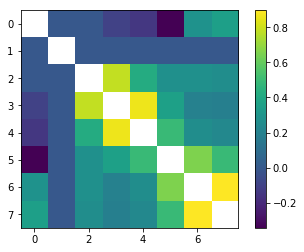

In [29]:
R_plot = R.df().as_matrix()
R_plot[np.abs(R_plot)>.9] = np.nan
plt.imshow(R_plot, interpolation='nearest', cmap='viridis')
plt.colorbar()

## GSA results

In [37]:
df = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".msn")),skipinitialspace=True)
df.loc[:,"parnme"] = df.pop("parameter_name").apply(lambda x : x.lower().replace("log(",'').replace(')',''))
df.index = df.parnme
df

,n_samples,sen_mean,sen_mean_abs,sen_std_dev,parnme
parnme,,,,,
rch_0,4,-2.755680e+04,4.646070e+04,7.951330e+04,rch_0
rch_1,4,-5.456970e-12,5.456970e-12,4.455600e-12,rch_1
hk_z01,4,5.209030e+01,9.575620e+01,1.654840e+02,hk_z01
hk_z02,4,-1.021740e+04,1.784460e+04,2.435460e+04,hk_z02
hk_z03,4,3.530400e+04,5.249780e+04,6.082660e+04,hk_z03
hk_z04,4,-2.102900e+04,2.113080e+04,2.581210e+04,hk_z04
hk_z05,4,-2.299230e+03,1.250960e+04,1.704220e+04,hk_z05
hk_z06,4,1.294320e+04,1.783130e+04,2.239260e+04,hk_z06


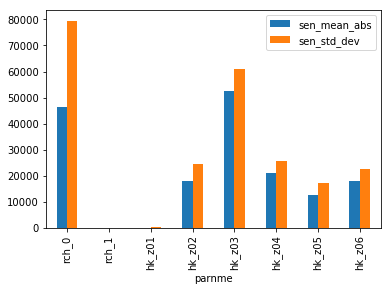

In [40]:
df.loc[:,["sen_mean_abs","sen_std_dev"]].plot(kind="bar")

### Interesting!  ``hk_z03`` is more sensitive across parameter space compared to the other HK parameters...and ``rch_0`` is suffering from non-linearity!